**Установка библиотек**

In [2]:

%pip install pandas numpy tensorflow keras matplotlib seaborn regex

%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\Machcreator\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\Machcreator\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


**Импорт библиотек**

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pickle
from collections import Counter
import os

**Подавление предупреждений TF (опционально)**

In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

**Настройка визуализации**

In [5]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

**Создание папки для результатов** 

In [6]:
os.makedirs('results', exist_ok=True)

**Загрузка датасета**


In [7]:
df = pd.read_csv('rusentitweet_full.csv')
print(f"Загружено твитов: {len(df)}")

df['text_length'] = df['text'].astype(str).apply(len)

Загружено твитов: 13392


**2.1 Визуализация характеристик датасета**

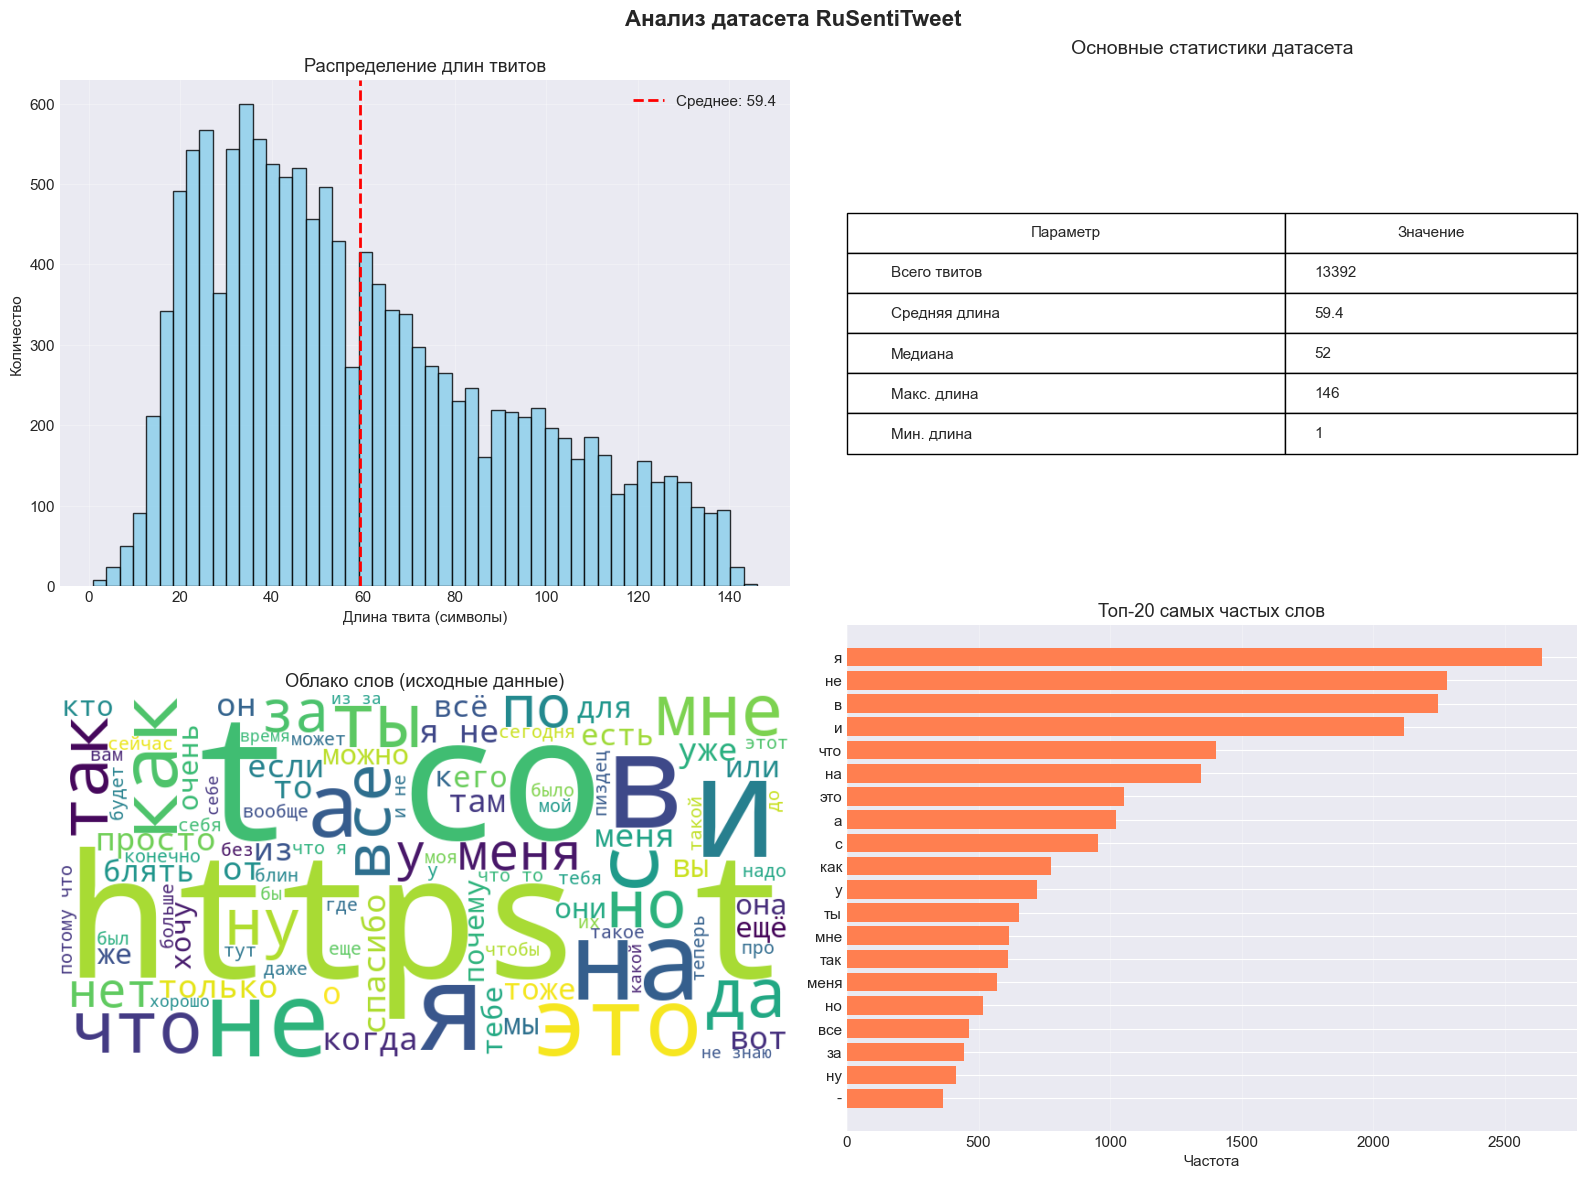

In [8]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Анализ датасета RuSentiTweet', fontsize=16, fontweight='bold')

# 1. Гистограмма длин твитов
axes[0, 0].hist(df['text_length'], bins=50, color='skyblue', edgecolor='black', alpha=0.8)
axes[0, 0].axvline(df['text_length'].mean(), color='red', linestyle='--', linewidth=2,
                   label=f'Среднее: {df["text_length"].mean():.1f}')
axes[0, 0].set_xlabel('Длина твита (символы)')
axes[0, 0].set_ylabel('Количество')
axes[0, 0].set_title('Распределение длин твитов')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Таблица статистики
stats = {
    'Всего твитов': len(df),
    'Средняя длина': f"{df['text_length'].mean():.1f}",
    'Медиана': f"{df['text_length'].median():.0f}",
    'Макс. длина': df['text_length'].max(),
    'Мин. длина': df['text_length'].min()
}
axes[0, 1].axis('off')
table_data = [[k, v] for k, v in stats.items()]
table = axes[0, 1].table(cellText=table_data,
                         colLabels=['Параметр', 'Значение'],
                         cellLoc='left', loc='center',
                         colWidths=[0.6, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)
axes[0, 1].set_title('Основные статистики датасета', fontsize=14, pad=20)

# 3. Облако слов
text_all = ' '.join(df['text'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      max_words=100, colormap='viridis').generate(text_all)
axes[1, 0].imshow(wordcloud, interpolation='bilinear')
axes[1, 0].axis('off')
axes[1, 0].set_title('Облако слов (исходные данные)')

# 4. Топ-20 самых частых слов — ИСПРАВЛЕНО!
all_text = ' '.join(df['text'].astype(str))        # Сначала объединяем
words = all_text.lower().split()                   # Потом lower() и split()
word_freq = Counter(words).most_common(20)
words_list, counts = zip(*word_freq)

axes[1, 1].barh(range(len(words_list)), counts, color='coral')
axes[1, 1].set_yticks(range(len(words_list)))
axes[1, 1].set_yticklabels(words_list)
axes[1, 1].invert_yaxis()
axes[1, 1].set_xlabel('Частота')
axes[1, 1].set_title('Топ-20 самых частых слов')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('results/01_dataset_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

**Предобработка текста**

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\w+', '@user', text)  # Замена вместо удаления
    text = re.sub(r'#(\w+)', r'\1', text)  # Убираем # но оставляем слово
    text = re.sub(r'[^\w\s\u0400-\u04FF]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

texts_cleaned = [clean_text(t) for t in df['text'].astype(str) if len(clean_text(t)) > 5]

print(f"Текстов после очистки: {len(texts_cleaned)}")

# Пример до/после
sample_idx = 0
print(f"\nДО: {df['text'].iloc[sample_idx]}")
print(f"ПОСЛЕ: {texts_cleaned[sample_idx] if sample_idx < len(texts_cleaned) else 'N/A'}")

Текстов после очистки: 12737

ДО: @varlamov @McFaul На
ПОСЛЕ: велл они всё равно что мусор так что ничего страшного


**ТОКЕНИЗАЦИЯ (WORD-LEVEL)**

In [23]:
max_vocab = 15000  
tokenizer = Tokenizer(num_words=max_vocab, oov_token='<OOV>')
tokenizer.fit_on_texts(texts_cleaned)

vocab_size = max_vocab
max_sequence_len = 35  

print(f"Размер словаря: {vocab_size}")
print(f"Макс. длина последовательности: {max_sequence_len}")

# Создание n-gram последовательностей
input_sequences = []
for line in texts_cleaned:
    token_list = tokenizer.texts_to_sequences([line])[0]
    if len(token_list) < 2:
        continue
    for i in range(2, len(token_list) + 1):
        n_gram = token_list[:i]
        input_sequences.append(n_gram)

print(f"Создано последовательностей: {len(input_sequences)}")

# Паддинг
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')

X = input_sequences[:, :-1]   # Все кроме последнего
y = input_sequences[:, -1]    # Последний токен — цель

y = tf.keras.utils.to_categorical(y, num_classes=vocab_size)

print(f"Форма X: {X.shape}")
print(f"Форма y: {y.shape}")

Размер словаря: 15000
Макс. длина последовательности: 35
Создано последовательностей: 84034
Форма X: (84034, 34)
Форма y: (84034, 15000)


**Модель LSTM**

In [24]:
model = Sequential([
    Embedding(vocab_size, 128, input_length=max_sequence_len-1),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    LSTM(100),
    Dropout(0.3),
    Dense(vocab_size // 2, activation='relu'),
    Dropout(0.2),
    Dense(vocab_size, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top5')]
)

model.summary()

# Визуализация архитектуры
try:
    plot_model(model, to_file='results/04_model_architecture.png',
               show_shapes=True, show_layer_names=True, dpi=300)
    print("Схема архитектуры сохранена")
except:
    print("Не удалось сохранить схему (graphviz не установлен)")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 34, 128)           1920000   
                                                                 
 bidirectional_1 (Bidirecti  (None, 34, 256)           263168    
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 34, 256)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               142800    
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 7500)              757500    
                                                      

**Обучение**

In [25]:

history = model.fit(
    X, y,
    batch_size=128,
    epochs=10,  
    validation_split=0.1,
    verbose=1
)

Epoch 1/10
591/591 [==============================] - 924s 2s/step - loss: 7.2578 - accuracy: 0.1124 - top5: 0.2087 - val_loss: 6.2178 - val_accuracy: 0.2116 - val_top5: 0.3115
Epoch 2/10
591/591 [==============================] - 895s 2s/step - loss: 6.8900 - accuracy: 0.1214 - top5: 0.2213 - val_loss: 6.1523 - val_accuracy: 0.2110 - val_top5: 0.3187
Epoch 3/10
591/591 [==============================] - 935s 2s/step - loss: 6.5910 - accuracy: 0.1332 - top5: 0.2337 - val_loss: 6.1602 - val_accuracy: 0.2093 - val_top5: 0.3227
Epoch 4/10
591/591 [==============================] - 925s 2s/step - loss: 6.3128 - accuracy: 0.1403 - top5: 0.2468 - val_loss: 6.2128 - val_accuracy: 0.2073 - val_top5: 0.3253
Epoch 5/10
591/591 [==============================] - 953s 2s/step - loss: 6.0509 - accuracy: 0.1479 - top5: 0.2593 - val_loss: 6.3541 - val_accuracy: 0.2078 - val_top5: 0.3271
Epoch 6/10
591/591 [==============================] - 964s 2s/step - loss: 5.7873 - accuracy: 0.1562 - top5: 0.2710

**Анализ обучения**

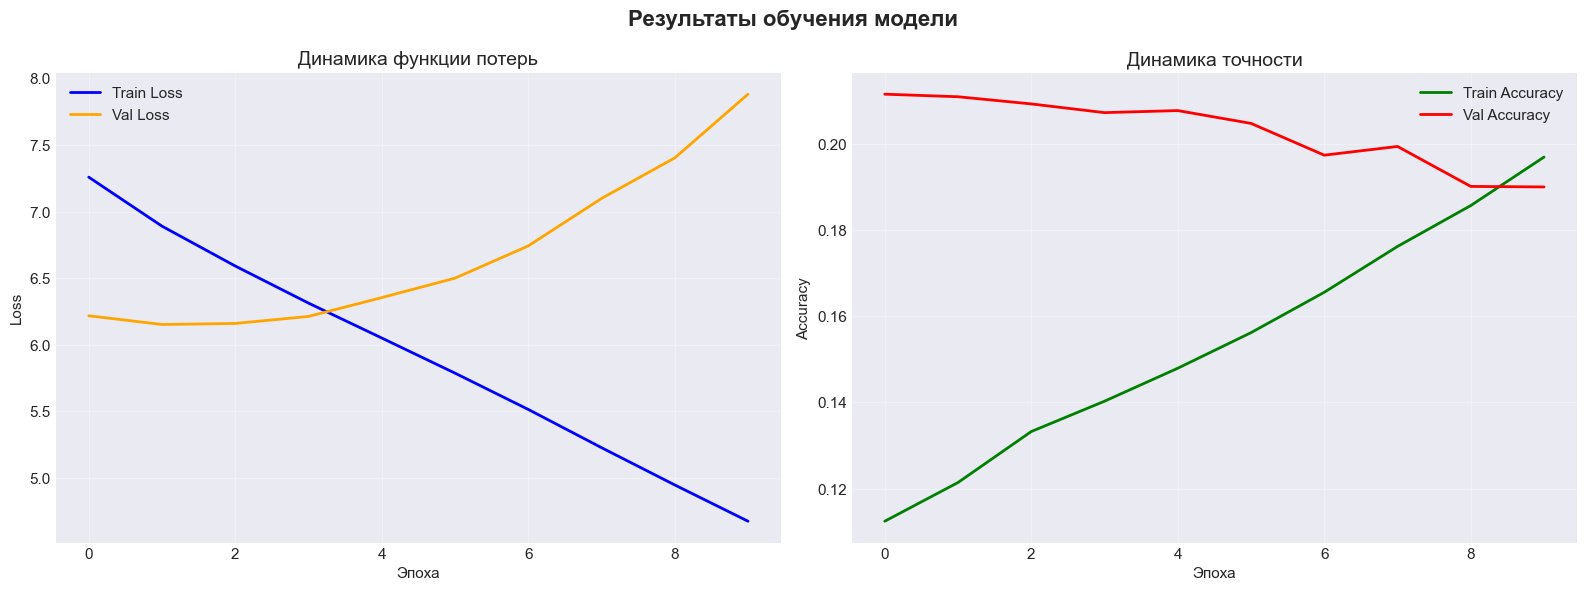

In [26]:

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Результаты обучения модели', fontsize=16, fontweight='bold')


axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2, color='blue')
axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2, color='orange')
axes[0].set_title('Динамика функции потерь', fontsize=14)
axes[0].set_xlabel('Эпоха')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)


axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2, color='green')
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2, color='red')
axes[1].set_title('Динамика точности', fontsize=14)
axes[1].set_xlabel('Эпоха')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/05_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

**Генерация поста**

In [27]:
def generate_post(seed_text, next_words=30, temperature=0.7):
    generated = seed_text.lower()
    
    for _ in range(next_words):
        # Токенизируем текущий текст
        token_list = tokenizer.texts_to_sequences([generated])[0]
        token_list = token_list[-(max_sequence_len-1):]  # Последние токены
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        
        # Предсказание вероятностей
        preds = model.predict(token_list, verbose=0)[0]
        
        # Temperature sampling
        preds = np.asarray(preds).astype('float64')
        preds = np.log(preds + 1e-10) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        
        # Выбор следующего индекса
        next_index = np.random.choice(len(preds), p=preds)
        
        # Находим слово
        next_word = tokenizer.index_word.get(next_index, '')
        if next_word:
            generated += " " + next_word
    
    return generated.strip()

# Тестирование
print("\nПРИМЕРЫ ГЕНЕРАЦИИ:")
seeds = ["привет как дела", "сегодня", "россия", "я думаю что", "погода"]
for seed in seeds:
    print(f"\nSeed: '{seed}'")
    for t in [0.5, 0.8, 1.0]:
        print(f"  T={t}: {generate_post(seed, next_words=25, temperature=t)}")


ПРИМЕРЫ ГЕНЕРАЦИИ:

Seed: 'привет как дела'
  T=0.5: привет как дела ещё <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> гэж <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> байх <OOV> байсан <OOV>
  T=0.8: привет как дела возвращается двое <OOV> с <OOV> <OOV> и <OOV> <OOV> 52 или н <OOV> льготных <OOV> человек новых <OOV> рекомендую держит в <OOV> детьми <OOV> только
  T=1.0: привет как дела узнали если мне надо бесит что у парочки о ними учить а где может нет то ли все прошу еще ест адрес и весьма какойто

Seed: 'сегодня'
  T=0.5: сегодня <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> хийсэн <OOV> <OOV> <OOV>
  T=0.8: сегодня в первой году друзья просто я без <OOV> рублей на <OOV> этих <OOV> лекарств <OOV> точно офигенно знайте общее тоже что нужно было не дойду
  T=1.0: сегодня самое буду <OOV> смотрят или потом <OOV> умеют сюда чтоб в принципе до лицо вообще еще посмотреть просто бупать

**Тестирование**

In [20]:
print("\n" + "="*60)
print("ПРИМЕРЫ ГЕНЕРАЦИИ")
print("="*60)

test_seeds = [
    "сегодня",
    "россия",
    "я думаю",
    "новости",
    "погода"
]

for seed in test_seeds:
    print(f"\n--- Seed: '{seed}' ---")
    
    # Разные температуры
    for temp in [0.5, 0.8, 1.2]:
        result = generate_post(seed, next_words=20, temperature=temp)
        print(f"T={temp}: {result}")


ПРИМЕРЫ ГЕНЕРАЦИИ

--- Seed: 'сегодня' ---
T=0.5: сегодня центральный рынок почти мёртв ночи я знаю сколько нужно было руку <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
T=0.8: сегодня суббота а я просто убил пока <OOV> <OOV> немного себе <OOV> и чисто а <OOV> <OOV> <OOV> то че перевоспитается
T=1.2: сегодня выйти на карантине и <OOV> три любимых <OOV> <OOV> это что вам буду считать что мои видео твиттер станет мне

--- Seed: 'россия' ---
T=0.5: россия получила <OOV> с <OOV> столе с помощью родителей пропал <OOV> <OOV> она хозяин в качестве <OOV> в москве русская весна
T=0.8: россия пойти не убить себя пока я пока не гей папа <OOV> то не против <OOV> то крышу <OOV> <OOV> <OOV>
T=1.2: россия в <OOV> не движении даже надеюсь на <OOV> не <OOV> ещё немного ничего дрочить не страшно не <OOV> <OOV> <OOV>

--- Seed: 'я думаю' ---
T=0.5: я думаю что есть <OOV> <OOV> и десятого доктора продавали шо <OOV> <OOV> <OOV> тал дээр <OOV> blue <OOV> байна via <OOV>
T=0.8: я думаю об этом ретви

**ЛУЧШИЕ РЕЗУЛЬТАТЫ**

In [16]:
print("\n" + "="*60)
print("ФИНАЛЬНЫЕ ПОСТЫ (оптимальная температура)")
print("="*60)

for i in range(5):
    seed = np.random.choice(["сегодня", "я считаю", "новости", "россия"])
    post = generate_post(seed, next_words=25, temperature=0.7)
    print(f"\n{i+1}. {post}")


ФИНАЛЬНЫЕ ПОСТЫ (оптимальная температура)

1. новости ингушетии сегодня скандал актуально <OOV> <OOV> <OOV> <OOV> болон <OOV> мөнгө <OOV> russian <OOV> <OOV> <OOV> <OOV> a <OOV> бла бла на самом деле хорошее

2. россия 2 <OOV> на <OOV> и какого хрена живут в человека <OOV> под ребята пиздец друзья спасибо розе за совет мяяяяяяяя а блин как продвигать знакомых

3. новости дети вышли на весну в пятницу сборник выступлений в <OOV> <OOV> <OOV> е <OOV> некорректно будет эмоции на <OOV> из людей мужиков вот я <OOV>

4. россия получила <OOV> со <OOV> в <OOV> а <OOV> <OOV> ну вот что за вид во <OOV> во втором <OOV> программы <OOV> <OOV> с мамой не

5. новости ингушетии сегодня скандал актуально <OOV> <OOV> <OOV> <OOV> болон <OOV> ганц <OOV> <OOV> <OOV> байна via <OOV> <OOV> болсон байх өө <OOV> игроки өөрсдөө өргөлийн


**Сохранение модели**

In [17]:
model.save('post_generator_model.h5')
print("\n✓ Модель сохранена: post_generator_model.h5")

# Сохранение токенизатора
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("✓ Токенизатор сохранен: tokenizer.pkl")

C:\Users\Machcreator\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



✓ Модель сохранена: post_generator_model.h5
✓ Токенизатор сохранен: tokenizer.pkl
